# Introdução

Esta análise é baseada no dataset `uscrime` -> [link to download](http://www.statsci.org/data/general/uscrime.txt).
A ideia é desenvolver um modelo preditivo capaz de calcular a taxa de criminalidade baseado nas demais variáveis presentes no dataset.

# Descrição

Criminologistas estão interessados no efeito dos regimes de punição nas taxas de criminalidade. Isto foi estudado utilizando dados agregados de 47 estados dos EUA em 1960. O conjunto de dados contém as seguintes colunas:

# Variável - Descrição

- M - Percentage of males aged 14–24 in total state population.
- So - Indicator variable for a southern state.
- Ed - Mean years of schooling of the population aged 25 years or over.
- Po1 - Per capita expenditure on police protection in 1960.
- Po2 - Per capita expenditure on police protection in 1959.
- LF - Labour force participation rate of civilian urban males in the age-group 14-24.
- M.F - Number of males per 100 females.
- Pop - State population in 1960 in hundred thousands.
- NW - Percentage of nonwhites in the population.
- U1 - Unemployment rate of urban males 14–24.
- U2 - Unemployment rate of urban males 35–39.
- Wealth - Median value of transferable assets or family income.
- Ineq - Income inequality: percentage of families earning below half the median income.
- Prob - Probability of imprisonment: ratio of number of commitments to number of offenses.
- Time - Average time in months served by offenders in state prisons before their first release.
- Crime - Crime rate: number of offenses per 100,000 population in 1960.

In [536]:
# Import of main modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import total_ordering
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score
from sklearn.feature_selection import RFE

In [537]:
%matplotlib inline

In [538]:
# Importing data
# In this case read_csv method was used to read .txt file.
# This method is very powerful to deal with as many problems as we can imagine!
# Parameter sep was set to tab ('\t')
uscrime_df = pd.read_csv('./dataset/uscrime.txt', sep='\t')

# Análise Exploratória de dados

Em um primeiro momento serão utilizados os métodos `.head()`, `.info()` e `.describe()`.

- .head() -> Traz algumas entradas do dataset original, recebe como parâmetro o número de linhas que deseja-se visualizar, por default `n=5`.

In [539]:
uscrime_df.head()

,M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time,Crime
0,15.1,1,9.1,5.8,5.6,0.510,95.0,33,30.1,0.108,4.1,3940,26.1,0.084602,26.2011,791
1,14.3,0,11.3,10.3,9.5,0.583,101.2,13,10.2,0.096,3.6,5570,19.4,0.029599,25.2999,1635
2,14.2,1,8.9,4.5,4.4,0.533,96.9,18,21.9,0.094,3.3,3180,25.0,0.083401,24.3006,578
3,13.6,0,12.1,14.9,14.1,0.577,99.4,157,8.0,0.102,3.9,6730,16.7,0.015801,29.9012,1969
4,14.1,0,12.1,10.9,10.1,0.591,98.5,18,3.0,0.091,2.0,5780,17.4,0.041399,21.2998,1234


- .info() -> retorna informações importantes sobre o dataset, como o número de entradas, estimativa de dados faltantes em cada coluna, o tipo de cada coluna e a memória utilizada para alocação do dataframe.

Obs: Por padrão, as features numéricas em pandas alocam 32 ou 64 bits (`float64` ou `float32` e `int64` ou `int32`), é interessante, no caso de se trabalhar com conjuntos de dados mais volumosos e que não necessitam deste espaço na memória, que se altere os tipos das variáveis para `float16` e `int8`. Esta alteração é capaz de salvar um enorme espaço na memória.

In [540]:
uscrime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M       47 non-null     float64
 1   So      47 non-null     int64  
 2   Ed      47 non-null     float64
 3   Po1     47 non-null     float64
 4   Po2     47 non-null     float64
 5   LF      47 non-null     float64
 6   M.F     47 non-null     float64
 7   Pop     47 non-null     int64  
 8   NW      47 non-null     float64
 9   U1      47 non-null     float64
 10  U2      47 non-null     float64
 11  Wealth  47 non-null     int64  
 12  Ineq    47 non-null     float64
 13  Prob    47 non-null     float64
 14  Time    47 non-null     float64
 15  Crime   47 non-null     int64  
dtypes: float64(12), int64(4)
memory usage: 6.0 KB


- .describe() -> Cálculo de diversas estatísticas relevantes para as variáveis numéricas como média, mediana, valores mínimos e máximos entre outros.

In [541]:
# Utilizei arredondamento para facilitar a visualização dos dados lembrando que como pandas é baseado em numpy as operações
# são facilmente aplicáveis a todos os valores do dataframe.
round(uscrime_df.describe(), 3)

,M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time,Crime
count,47.000,47.000,47.000,47.000,47.000,47.000,47.000,47.000,47.000,47.000,47.000,47.000,47.00,47.000,47.000,47.000
mean,13.857,0.340,10.564,8.500,8.023,0.561,98.302,36.617,10.113,0.095,3.398,5253.830,19.40,0.047,26.598,905.085
std,1.257,0.479,1.119,2.972,2.796,0.040,2.947,38.071,10.283,0.018,0.845,964.909,3.99,0.023,7.087,386.763
min,11.900,0.000,8.700,4.500,4.100,0.480,93.400,3.000,0.200,0.070,2.000,2880.000,12.60,0.007,12.200,342.000
25%,13.000,0.000,9.750,6.250,5.850,0.530,96.450,10.000,2.400,0.080,2.750,4595.000,16.55,0.033,21.600,658.500
50%,13.600,0.000,10.800,7.800,7.300,0.560,97.700,25.000,7.600,0.092,3.400,5370.000,17.60,0.042,25.801,831.000
75%,14.600,1.000,11.450,10.450,9.700,0.593,99.200,41.500,13.250,0.104,3.850,5915.000,22.75,0.054,30.451,1057.500
max,17.700,1.000,12.200,16.600,15.700,0.641,107.100,168.000,42.300,0.142,5.800,6890.000,27.60,0.120,44.000,1993.000


# Inconsistências nos tipos de variáveis

Observando a descrição das variáveis, suas estruturas de dados e os valores das estatísticas, observa-se que temos uma inconsistencia com a feature `So`. Esta é uma feature categórica, que indica se a entrada é ou não de um estado do sul, logo cálculos como média, desvio padrão e quartis não fazem muito sentido. Neste caso, é necessário fazer uma alteração no tipo da variável para categórica e aplicar novamente o método .describe(). Será possível observar uma adaptação do pandas para tratar este tipo de dado.

In [542]:
# method .astype() to transform data type to category
uscrime_df[['So']].astype('category').describe()

,So
count,47
unique,2
top,0
freq,31


Alterando-se o tipo do dado para categórico observa-se a alteração nas estatisticas cálculadas pelo método `.describe()`, agora posso analisar quantos valores únicos a variável possui (no caso, 0 e 1), qual o valor mais frequente (top = 0) e sua frequência (31 ocorrências em 47 aproximadamente 65,96%).  
Como observado, há apenas duas categorias para esta variável, com isso manterei esta coluna como tipo inteiro, já que esta poderá ser utilizada como feature no desenvolvimento do modelo preditivo.  
Em casos onde ocorrem mais opções de categorias, podemos utilizar metodologias como `one hot encoding` ou `get_dummies` para transformar estas features em features numéricas, onde seriam criadas novas colunas no data frame, cada uma representando uma categoria (lembrando-se de criar n-1 novas colunas para que não aja uma redundância que prejudique o desempenho do modelo). A ideia desta metodologia é que ao criar categorias numéricas, os modelos de predição não considerem números mais altos como mais importantes e com a criação de uma coluna para cada categoria, garanto que os valores possíveis sejam somente 1 (caso pertença a categoria) e 0 (caso não pertença).

# Tratamento de Dados Faltantes

Esta é uma etapa importantíssima da análise exploratória de dados, neste caso não há ocorrencia de dados faltantes mas caso houvesse teriamos que pensar em uma estratégia para tratá-los. Seguem algumas possibilidades:

- Caso seja uma quantidade pouco significativa com relação ao volume total de dados, posso simplesmente deletar as entradas com dados faltantes (lembrando que a definição do que seria 'pouco significativo' varia de caso pra caso).
- Podemos utilizar estatísticas para preenchimento, como média, mediana, valores mínimos e máximos.
- Podemos utilizar uma regra de negócio para preenchimento.
- Podemos nos basear em outras variáveis para obtenção desses valores, tanto através de relações diretas quanto através de modelos preditivos.

Enfim, provavelmente existem outras formas de analisar e fazer o preenchimento de dados faltantes sendo esta uma análise peculiar de cada conjunto de dados.

In [543]:
# Como uma análise rápida da presença ou não de dados faltantes posso rodar a seguinte linha de código:

has_nan = any(uscrime_df.isna().sum())
print(f"Is there any missing value? -> {'Yes' if has_nan else 'No'}")

Is there any missing value? -> No


# Análise de correlação entre variáveis

Uma forma e efetiva de observar como as variáveis se relacionam, é análisar a correlação entre elas. O pandas já tem um método nativo .corr() que quando aplicado ao data frame, retorna como as variáveis numéricas se relacionam umas com as outras.

In [544]:
# Neste caso, criei um novo data frame para receber a correlação entre variáveis
uscrime_correlation_df = round(uscrime_df.corr(), 3)
uscrime_correlation_df

,M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time,Crime
M,1.000,0.584,-0.530,-0.506,-0.513,-0.161,-0.029,-0.281,0.593,-0.224,-0.245,-0.670,0.639,0.361,0.115,-0.089
So,0.584,1.000,-0.703,-0.373,-0.376,-0.505,-0.315,-0.050,0.767,-0.172,0.072,-0.637,0.737,0.531,0.067,-0.091
Ed,-0.530,-0.703,1.000,0.483,0.499,0.561,0.437,-0.017,-0.665,0.018,-0.216,0.736,-0.769,-0.390,-0.254,0.323
Po1,-0.506,-0.373,0.483,1.000,0.994,0.121,0.034,0.526,-0.214,-0.044,0.185,0.787,-0.631,-0.473,0.103,0.688
Po2,-0.513,-0.376,0.499,0.994,1.000,0.106,0.023,0.514,-0.219,-0.052,0.169,0.794,-0.648,-0.473,0.076,0.667
LF,-0.161,-0.505,0.561,0.121,0.106,1.000,0.514,-0.124,-0.341,-0.229,-0.421,0.295,-0.270,-0.250,-0.124,0.189
M.F,-0.029,-0.315,0.437,0.034,0.023,0.514,1.000,-0.411,-0.327,0.352,-0.019,0.180,-0.167,-0.051,-0.428,0.214
Pop,-0.281,-0.050,-0.017,0.526,0.514,-0.124,-0.411,1.000,0.095,-0.038,0.270,0.308,-0.126,-0.347,0.464,0.337
NW,0.593,0.767,-0.665,-0.214,-0.219,-0.341,-0.327,0.095,1.000,-0.156,0.081,-0.590,0.677,0.428,0.230,0.033
U1,-0.224,-0.172,0.018,-0.044,-0.052,-0.229,0.352,-0.038,-0.156,1.000,0.746,0.045,-0.064,-0.007,-0.170,-0.050


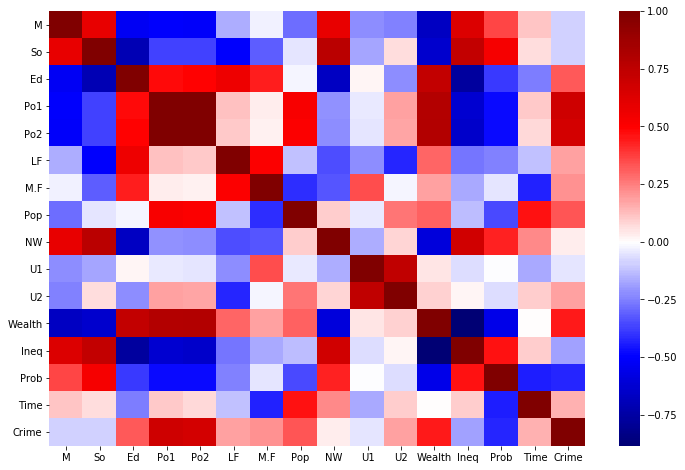

In [545]:
# Geração do mapa de calor para as correlações entre variáveis numéricas do data frame.
plt.figure(figsize=(12, 8))
sns.heatmap(uscrime_correlation_df, center=0, cmap='seismic');

In [546]:
correlation_with_crime = uscrime_correlation_df.loc['Crime'][uscrime_correlation_df.columns != 'Crime']
correlation_with_crime

M        -0.089
So       -0.091
Ed        0.323
Po1       0.688
Po2       0.667
LF        0.189
M.F       0.214
Pop       0.337
NW        0.033
U1       -0.050
U2        0.177
Wealth    0.441
Ineq     -0.179
Prob     -0.427
Time      0.150
Name: Crime, dtype: float64

# Observações importantes:

Considerando as correlações e mapa de calor, observa-se que as variáveis `Po1` e `Po2` são as que apresentam maiores correlações com a variável alvo (respectivamente 0.688 e 0.667), observa-se também que estas variáveis apresentam correlação de quase 1 entre elas (0.994), isto significa que posso utilizar somente uma delas em meu modelo preditivo reduzindo assim a dimensão do problema. Neste caso irei utilizar a variável `Po1`que apresenta maior correlação com a variável alvo.
As variáveis `M`, `So`, `NW` e  `U1` apresentam correlações menores que 0.1 e -0.1 logo não serão consideradas no desenvolvimento do modelo preditivo.
Nesta etapa, vou utilizar do desenvolvimento orientado a objetos para desenvolvimento do modelo preditivo, a ideia é que com esta modelagem, seja possível criar e comparar modelos, com objetivo de se obter o melhor modelo possível considerando os critérios adotados.

# Desenvolvimento da classe CrimeRatePredictor

Esta classe será utilizada para abstrair todas as etapas do desenvolvimento do modelo de predição, a ideia é fazer um desenvolvimento focado na reusabilidade, escalabilidade e manutenção. Fazendo também uma boa definição de cada método, é possível executar testes unitários de maneira bem simples e direta.

Vou comentar um pouco sobre os métodos mais importantes desta classe:

- `feature_selection()` - Este método, define quais features serão utilizadas no modelo preditivo. Em um primeiro momento, utilizei a análise de correlações, tendo como parâmetro um fator de corte.

- `transform_data_with_selected_features()` - Este método aplica as features selecionadas no data frame, obtendo o data frame específico que será utilizado no modelo preditivo. Há também um método estático que será utilizado para transformar novos dados.

- `split_data_into_train_test_part()` - Método utilizado para particionar os dados originais em dados de treino e dados de teste com isso poderei validar o modelo calculando métricas que possam ser comparaveis.

- `fit_model_to_predict()` - Método responsável por calibrar o modelo. Em um primeiro momento utilizei regressão linear.

- `make_predictions_with_test_data()` - Método responsável por calcular predizer resultado utilizando os dados de teste com objetivo de serem utilizados no calculo das métricas de validação.

- `calculate_model_metric()` - Esta função calcula a métrica de avaliação dos modelos utilizando as predições dos dados de teste. A métrica calculada é alocada em um atributo, este atributo será utilizado nos métodos de ordenação, permitindo que objetos da classe possam ser ordenados quando dispostos em uma coleção.

- `@total_ordering`, `__eq__()` e `__lt__()` - Definem métodos que permitem que objetos desta classe sejam ordenáveis de acordo com algum critério espefico. Neste caso vou utilizar a métrica.


# Métrica utilizada: explained_variance_score:

Esta métrica, explica a dispersão dos erros de um determinado conjunto de dados. Quanto mais próximo de 1, melhor o modelo, indicando melhores quadrados do desvios padrão dos erros.

[referencia 1:](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.explained_variance_score.html#sklearn.metrics.explained_variance_score)  
[referencia 2:](https://books.google.com.br/books?id=7S6WDwAAQBAJ&pg=PA332&lpg=PA332&dq=explained_variance_score&source=bl&ots=awF03vf-ai&sig=ACfU3U0TjsTsxfY6KxJfUFuHEUGpR3IM4w&hl=pt-BR&sa=X&ved=2ahUKEwiS2M3TqK_qAhXmGbkGHaNAB4oQ6AEwDnoECAoQAQ#v=onepage&q=explained_variance_score&f=false)

In [547]:
@total_ordering
class CrimeRatePredictor(object):
    """
    This class will be used as a model for specific child classes for each considered predictive model.
    """
    
    def __init__(self, crime_df):
        
        # This class will delete 'Po2' from original data frame once we decided didn't consider it in our analysis.
        self.crime_df = crime_df.copy()
        del (self.crime_df['Po2'])
        
        # List of features that will be used according some criteria
        self.corr_factor = 0
        self.features_to_use = []
        
        # Target name in case of use it in other methods
        self.target_name = 'Crime'
        
        # Complete data from target variable
        self.target_data = self.crime_df[self.target_name]
        
        # Attribute to allocate complete data 
        self.complete_x_data = self.crime_df.drop(columns='Crime')
        
        # Attributes that will be used into train x test split
        self.x_train = 'This attribute is not defined yet'
        self.x_test = 'This attribute is not defined yet'
        self.y_train = 'This attribute is not defined yet'
        self.y_test = 'This attribute is not defined yet'
        
        # Number that ensures that the numerical experiment can be reproduced.
        self.random_seed = 42
        
        # Infos about prediction model.
        self.model_name = 'Linear Regression'
        self.model = LinearRegression()
        self.model_metric = 'This attribute is not defined yet'
        
        # Values predicted using x_test to validate the model.
        self.y_test_pred = 'This attribute is not defined yet'

    
    @property
    def model_info(self):
        
        complete_info =  f"Model: {self.model_name} "
        complete_info += '-> '
        complete_info += f'Correlation Factor: {self.corr_factor} '
        complete_info += '-> '
        complete_info += f'Number of features used: {len(self.features_to_use)} '
        complete_info += '-> '
        complete_info += f'Metric - Explained Variance Score: {round(self.model_metric, 3)}'
        return complete_info
    
    @property
    def print_shape(self):
        """
        Method to print the number of rows and columns.
        """
        print(f'Number of lines: {self.crime_df.shape[0]}')
        print(f'Number of columns: {self.crime_df.shape[1]}')
        
    @property
    def print_column_names(self):
        """
        Method to print column names of the original data frame.
        """
        print('Column names:')
        
        for column in self.crime_df.columns:
            
            print(f'             {column} - type: {self.crime_df[column].dtype}')
        
    def show_dataframe_information(self):
        """
        Show information about data frame used to develop this model.
        """
        print('========= Start Data Frame Information ==========')
        print('\n')
        self.print_shape
        self.print_column_names
        print('\n')
        print('========= Finish Data Frame Information ==========')
        
   
    def feature_selection(self, corr_factor: float) -> list:
        """
        Method based on a correlation factor to decide which features will be used to implement a predictive model.
        
        args:
        
            corr_factor: float -> factor that will be used to select most influent features. In this case, features that
                                  presents correlation with target greater than corr_factor or less than (-corr_factor).
                                  
        return: 
            
            self.features_to_use: list -> List of features that will be used defined by corr_factor criteria.
        """
        
        self.corr_factor = corr_factor
        # Create the correlational data frame.
        crime_df_corr = self.crime_df.corr()
        
        # Obtain the conditional to filter the correlation data frame considering the corr_factor
        evaluate_corr_factor_conditional = (crime_df_corr[self.target_name] >= corr_factor) \
                                           | (crime_df_corr[self.target_name] <= -corr_factor)
        
        # Select all features that achieve the corr_factor test.
        self.features_to_use = crime_df_corr[evaluate_corr_factor_conditional].index
        
        # Drop target column (Crime) and transform to list.
        self.features_to_use = self.features_to_use.drop(self.target_name).tolist()
        
        return self.features_to_use
        
    def transform_data_with_selected_features(self):
        """
        This method get data just using the selected features
        
        return:
            
            self.complete_x_data: pd.DataFrame -> Data Frame containing just selected features
        """
        
        self.x_train = self.x_train[self.features_to_use]
        self.x_test = self.x_test[self.features_to_use]
        print('x_train and x_test were transformed using feature selection.')
        
        
    def split_data_into_train_test_part(self, split_factor=0.3) -> str:
        """
        Method used to divide complete data into train/test data to use to fit and validate the predictive model.
        
        args:
            
            split_factor: float -> Value that deifne the partition between train and test. This factor refers to test quantity.
                          So, if split_factor equals 0.3 means that 30% of data will be used to test.
                          
        return:
        
            message: str -> Message that means everything works well, it's recomended that if an user wants to see and explore
                     train and test data, just access it by object attributes.
        """
        
        message = 'Data was splitted, to analyze the values, access the attributes: x_train, x_test, y_train, y_test.'
        
        splitted_results = train_test_split(self.complete_x_data, self.target_data, random_state=self.random_seed\
                                            , test_size=split_factor)
        
        self.x_train, self.x_test, self.y_train, self.y_test = splitted_results
        
        print(message)
    
    def fit_model_to_predict(self):
        """
        Method do calibrate the prediction model using x_train
        """
        self.model.fit(self.x_train, self.y_train)
        print(f'The {self.model_name} was fitted and is ready to use!')
        
    def make_predictions_with_test_data(self):
        """
        Method to predict results using x_test data in order to validade the model and server as input into metrics 
        calculations.
        """
        
        self.y_test_pred = self.model.predict(self.x_test)
        print(f'Results were predicted using x_test data in order to validade the model.')
        
    def calculate_model_metric(self):
        """
        Method to calculate the performance of the model that will be used to compare with others and make it orderable when
        within a collection.
        """
        self.model_metric = explained_variance_score(self.y_test, self.y_test_pred)
        return self.model_metric
    

    def tranform_external_data_with_selected_features(self, external_data: pd.DataFrame) -> pd.DataFrame:
        """
        Transform external data using the selected features
        
        args:
        
            external_data: pd.DataFrame -> New data to transform using the selected features.
            
        return:
        
            Modified data frame considering just selected features.
        
        """
        return external_data[self.features_to_use]
    

    def make_predictions_with_external_data(self, external_data: pd.DataFrame) -> np.array:
        """
        Make predictions using external data, remember that before this step, apply the method transform_external_data_with_
        selected_features.
        args:
        
            external_data: pd.DataFrame -> External, transformed data frame.
            
        return:
        
            numpy array with predictions for one or more entries.
        
        """
        return self.model.predict(external_data)

    # dunder methods to make object orderable into collections.
    def __eq__(self, other):
        
        return self.model_metric == other.model_metric
    
    def __lt__(self, other):
        
        return self.model_metric < other.model_metric

Neste ponto, tenho uma classe capaz de criar objetos que representam um modelo de predição para os dados presentes e, uscrime.txt. Aproveitando a reusabilidade do código posso facilmente criar diferentes modelos variando o valor de corte para a correlação, ordenando-os em uma lista obtendo assim o modelo com melhor métrica.

In [548]:
def create_prediction_crime_model(corr: float) -> CrimeRatePredictor:
    
    print(f"Creating an object with correlation factor = {corr}")
    
    # Pipeline to create a PredictCrimeModel
    
    # Create the object with uscrime data frame
    PredictCrimeModel = CrimeRatePredictor(uscrime_df)
    
    # Split data into train and test data with 0.3 (30% rate)
    PredictCrimeModel.split_data_into_train_test_part(0.3)
    
    # Select features considering the correlation value
    PredictCrimeModel.feature_selection(corr)
    
    # Tranform data using selected features
    PredictCrimeModel.transform_data_with_selected_features()
    
    # Fit the model using train data
    PredictCrimeModel.fit_model_to_predict()
    
    # Make predictions with test data
    PredictCrimeModel.make_predictions_with_test_data()
    
    # Calculate the metric based on Explained variance score
    PredictCrimeModel.calculate_model_metric()
    print(PredictCrimeModel.model_info)
    print('\n')
    
    return PredictCrimeModel

In [549]:
# In this step I'll create differente models using different

correlations = [0, 0.1, 0.2, 0.3, 0.4]


# Create a list of CrimeRatePredictor objects:

crime_predictors = [create_prediction_crime_model(corr) for corr in correlations]

crime_predictors = sorted(crime_predictors)

best_model_corr = crime_predictors[-1]

print('Best model information: ')
print(best_model_corr.model_info)

Creating an object with correlation factor = 0
Data was splitted, to analyze the values, access the attributes: x_train, x_test, y_train, y_test.
x_train and x_test were transformed using feature selection.
The Linear Regression was fitted and is ready to use!
Results were predicted using x_test data in order to validade the model.
Model: Linear Regression -> Correlation Factor: 0 -> Number of features used: 14 -> Metric - Explained Variance Score: 0.779


Creating an object with correlation factor = 0.1
Data was splitted, to analyze the values, access the attributes: x_train, x_test, y_train, y_test.
x_train and x_test were transformed using feature selection.
The Linear Regression was fitted and is ready to use!
Results were predicted using x_test data in order to validade the model.
Model: Linear Regression -> Correlation Factor: 0.1 -> Number of features used: 10 -> Metric - Explained Variance Score: 0.716


Creating an object with correlation factor = 0.2
Data was splitted, to ana

# Modelo em produção

Neste ponto, conseguimos avaliar diferentes modelos considerando diferentes conjuntos de features.  
Através do paradigma de orientação a objetos, conseguimos facilmente gerar os objetos que armazenam o modelo e ordena-los de acordo com a métrica, obtendo assim o melhor modelo com as premissas consideradas.
O melhor modelo utiliza todas as features e obtém um score de 0.78/1 considerando a métrica `explained variance score`. É possível entregar uma solução para um possível cliente agora, gerando valor e dando a tranquilidade para continuar trabalhando na melhoria do modelo.

# Utilizando o modelo para fazer novas predições

Vamos utilizar o melhor modelo até então, para calcular a taxa de criminalidade com o ponto adicional fornecido.

In [550]:
data_to_calculate = {'M':[14.0],
                     'So': [0],
                     'Ed': [10.0],
                     'Po1': [12.0],
                     'Po2': [15.5],
                     'LF': [0.640],
                     'M.F': [94.0],
                     'Pop': [150],
                     'NW': [1.1],
                     'U1': [0.120],
                     'U2': [3.6],
                     'Wealth': [3200],
                     'Ineq': [20.1],
                     'Prob': [0.04],
                     'Time': [39.0]}

data_df = pd.DataFrame(data_to_calculate)
data_df

,M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time
0,14.0,0,10.0,12.0,15.5,0.64,94.0,150,1.1,0.12,3.6,3200,20.1,0.04,39.0


In [551]:
transformed_data = best_model_corr.tranform_external_data_with_selected_features(data_df)
predict_value_corr = best_model_corr.make_predictions_with_external_data(transformed_data)


print(f'O valor predito para os novos dados é {round(predict_value_corr[0], 2)}')

O valor predito para os novos dados é 1024.44


# Herança e Polimorfismo

Da forma como o modelo foi contruido, podemos facilmente adicionar e alterar funcionalidades, corrigir possíveis erros sem afetar o todo e trabalhar bem em equipe onde cada membro do time pode focar em desenvolver ou melhorar uma funcionalidade especifica. Um conceito muito interessante e que pode ser aplicado em um desenvolvimento orientado a objetos, é a herança e polimorfismo. Podemos construir uma classe que herda as características (atributos e métodos) da classe atual, alterando apenas a funcionalidade de interesse.

# Selecionando features com o RFE

RFE é um modelo presente no módulo scikit learn e é utilizado para definir quais variáveis impactam mais no modelo preditivo. As variáveis vão sendo eliminadas uma a uma até chegar no vlaor estipulado. Neste caso, vou redefinir o método de seleção de features da classe CrimeRatePredictor e fazer a seleção eliminando de 1 a 5 variáveis

In [552]:
class CrimeRatePredictorUsingRFE(CrimeRatePredictor):
    
    def __init__(self, crime_df):
        
        super().__init__(crime_df)
        self.n_features_to_remove = None
        
        
    @property
    def model_info(self):
        
        complete_info =  f"Model: {self.model_name} "
        complete_info += '-> '
        complete_info += f'Number of features to remove: {self.n_features_to_remove} '
        complete_info += '-> '
        complete_info += f'Number of features used: {len(self.features_to_use)} '
        complete_info += '-> '
        complete_info += f'Metric - Explained Variance Score: {round(self.model_metric, 3)}'
        return complete_info
    
    def feature_selection(self, n_removed_features=None) -> list:
        """
        Method based on a RFE model to decide which features will be used to implement a predictive model.
        
        args:
        
            n_removed_features: int -> Define the number of features that will be eliminated.
                                  
        return: 
            
            self.features_to_use: list -> List of features that will be used defined by corr_factor criteria.
        """
        self.n_features_to_remove = n_removed_features
        
        # Define RFE model using Linear Regression to calculate.
        # n_removed_features define the number of features that will be eliminated.
        rfe = RFE(self.model, n_features_to_select=len(self.x_train.columns) - n_removed_features)
            
        # Fit RFE model using x_train and y_train
        rfe.fit(self.x_train, self.y_train)
            
        # Get info from RFE
        rfe_info =  pd.DataFrame({'column': self.x_train.columns,
                                      'bool': rfe.get_support()})
        only_true_rfe = rfe_info[rfe_info['bool'] == True]
        self.features_to_use = only_true_rfe['column'].tolist()
            
        
        return self.features_to_use

In [553]:
def create_prediction_crime_model_rfe(n_features: float) -> CrimeRatePredictorUsingRFE:
    
    print(f"Creating an object with n number of removed features = {n_features}")
    
    # Pipeline to create a PredictCrimeModel
    
    # Create the object with uscrime data frame
    PredictCrimeModel = CrimeRatePredictorUsingRFE(uscrime_df)
    
    # Split data into train and test data with 0.3 (30% rate)
    PredictCrimeModel.split_data_into_train_test_part(0.3)
    
    # Select features considering the correlation value
    PredictCrimeModel.feature_selection(n_features)
    
    # Tranform data using selected features
    PredictCrimeModel.transform_data_with_selected_features()
    
    # Fit the model using train data
    PredictCrimeModel.fit_model_to_predict()
    
    # Make predictions with test data
    PredictCrimeModel.make_predictions_with_test_data()
    
    # Calculate the metric based on Explained variance score
    PredictCrimeModel.calculate_model_metric()
    print(PredictCrimeModel.model_info)
    print('\n')
    
    return PredictCrimeModel

In [554]:
# In this step I'll create differente models using different number of features to remove.

n_features_to_remove = [1, 2, 3, 4, 5]


# Create a list of CrimeRatePredictorUsingRFE objects:

crime_predictors = [create_prediction_crime_model_rfe(n) for n in n_features_to_remove]

crime_predictors = sorted(crime_predictors)

best_model_rfe = crime_predictors[-2]

print('Best model information: ')
print(best_model_rfe.model_info)

Creating an object with n number of removed features = 1
Data was splitted, to analyze the values, access the attributes: x_train, x_test, y_train, y_test.
x_train and x_test were transformed using feature selection.
The Linear Regression was fitted and is ready to use!
Results were predicted using x_test data in order to validade the model.
Model: Linear Regression -> Number of features to remove: 1 -> Number of features used: 13 -> Metric - Explained Variance Score: 0.766


Creating an object with n number of removed features = 2
Data was splitted, to analyze the values, access the attributes: x_train, x_test, y_train, y_test.
x_train and x_test were transformed using feature selection.
The Linear Regression was fitted and is ready to use!
Results were predicted using x_test data in order to validade the model.
Model: Linear Regression -> Number of features to remove: 2 -> Number of features used: 12 -> Metric - Explained Variance Score: 0.766


Creating an object with n number of re

In [555]:
print('Features used in the best correlation model:')
display(','.join(best_model_corr.features_to_use))

print('Features used in the rfe model:')
display(','.join(best_model_rfe.features_to_use))

print(f'Correlation model - explained_variance_score: {round(best_model_corr.model_metric, 3)}')
print(f'RFE model - explained_variance_score: {round(best_model_rfe.model_metric, 3)}')

Features used in the best correlation model:


'M,So,Ed,Po1,LF,M.F,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time'

Features used in the rfe model:


'M,Ed,Po1,LF,M.F,U1,U2,Ineq,Prob,Time'

Correlation model - explained_variance_score: 0.779
RFE model - explained_variance_score: 0.818


O melhor resultado para o modelo que seleciona as features através das maiores correlações considerou todas as features para definição da regressão linear. Aplicando-se a seleção de features pelo RFE, observa-se que o melhor modelo eliminou 4 features, entre elas `Wealth` e `Pop` que embora apresentem correlações consideráveis com a variável alvo, prejudicam a regressão linear.  
Com isso, além do ganho de desempenho de `0.779` para `0.818`, ainda obtive um modelo mais performático que executa os cálculos considerando 4 features a menos.

In [556]:
transformed_data = best_model_rfe.tranform_external_data_with_selected_features(data_df)
predict_value_rfe = best_model_rfe.make_predictions_with_external_data(transformed_data)


print(f'O valor predito para os novos dados é {round(predict_value_rfe[0], 2)}')

O valor predito para os novos dados é 1222.06


In [557]:
print(f'Correlation model - Valor predito: {round(predict_value_corr[0], 2)}')
print(f'RFE model - Valor  predito: {round(predict_value_rfe[0], 2)}')

Correlation model - Valor predito: 1024.44
RFE model - Valor  predito: 1222.06


Este exemplo demonstrou o poder do paradigma da orientação a objetos aplicado a um projeto de ciência de dados, onde de forma simples é possível analisar cada parte do código em busca de melhor performance e melhor desempenho preditivo.  
Outras análises que podem ser feitas:

- Aplicação da redução de dimensionalidade utilizando PCA
- Inclusão de outras métricas para análise do modelo como `Mean Square Error` ou `Median Absolut Error`. Lembrando que para fazer isto basta seguir os conceitos de herança e polimorfismo para criar outra classe variando apenas o método que cálcula essas métricas.
- Análise de outros modelos de regressão.

In [558]:
print('The best model Information: ')
print(best_model_rfe.model_info)

The best model Information: 
Model: Linear Regression -> Number of features to remove: 4 -> Number of features used: 10 -> Metric - Explained Variance Score: 0.818


# Observação final:  

Outro ponto importante desta forma de desenvolvimento é a possibilidade de execução de testes unitários para cada etapa do código, fazendo com que a qualidade seja garantida, minimizando retrabalho e erros futuros. Sendo assim, podemos avançar com a cabeça mais tranquila para as próximas etapas.

Perguntas como:

- Será que meu modelo seleciona as features corretamente?
- Será que minha divisão entre dados de teste e treino esá sendo feita corretamente?

Entre outras, podem ser feitas e respondidas.

In [559]:
# Pipeline to create a PredictCrimeModel
    
# Create the object with uscrime data frame
PredictCrimeModel = CrimeRatePredictor(uscrime_df)
    
# Split data into train and test data with 0.3 (30% rate)
PredictCrimeModel.split_data_into_train_test_part(0.3)

Data was splitted, to analyze the values, access the attributes: x_train, x_test, y_train, y_test.


In [560]:
assert PredictCrimeModel.feature_selection(0.4) == ['Po1', 'Wealth', 'Prob']
assert round(len(PredictCrimeModel.x_train) / len(uscrime_df), 1) == 0.7

Assert que não retorna nada passou no teste =D